In [ ]:
!pip install transformers==4.40.0

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

from transformers import logging
logging.set_verbosity_error()

import os
import time
import torch
import pandas as pd
from tqdm.auto import tqdm

# 1) Import CheXagent
from transformers import AutoTokenizer, AutoModelForCausalLM
class CheXagent:
    def __init__(self, model_name="StanfordAIMI/CheXagent-2-3b"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.dtype  = torch.bfloat16 if "cuda" in self.device else torch.float32
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
        self.model     = AutoModelForCausalLM.from_pretrained(
            model_name,
            device_map="auto",
            trust_remote_code=True
        ).to(self.dtype).to(self.device).eval()

    def generate(self, paths, prompt):
        # build multimodal query
        q = self.tokenizer.from_list_format(
            [*({"image": p} for p in paths), {"text": prompt}]
        )
        conv = [
            {"from": "system", "value": "You are a helpful assistant."},
            {"from": "human",  "value": q},
        ]
    
        # 1) apply template → maybe a Tensor, maybe a dict
        out = self.tokenizer.apply_chat_template(
            conv, add_generation_prompt=True, return_tensors="pt"
        )
        if isinstance(out, torch.Tensor):
            input_ids = out.to(self.device)
        else:
            input_ids = out["input_ids"].to(self.device)
    
        # 2) generate
        output_ids = self.model.generate(
            input_ids,
            do_sample=False,
            num_beams=1,
            max_new_tokens=512,
            pad_token_id=self.tokenizer.eos_token_id,
            eos_token_id=self.tokenizer.eos_token_id,
        )[0]
    
        # 3) decode only the newly generated tokens
        gen = output_ids[input_ids.size(1) : ]
        response = self.tokenizer.decode(gen, skip_special_tokens=True)
        return response


    def disease_identification(self, paths, disease_list):
        prompt = "Given the CXR, identify any diseases. Options:\n" + ", ".join(disease_list)
        return self.generate(paths, prompt)


# 2) Setup paths & read GT
IMAGE_DIR = "/kaggle/input/chest-x-ray-images/test_data"
GT_CSV    = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"

gt_df = pd.read_csv(GT_CSV)
gt_df["ImageName"] = gt_df["ImageName"].apply(os.path.basename)

# 3) Define diseases & instantiate CheXagent
DISEASES = [c for c in gt_df.columns if c != "ImageName"]
agent = CheXagent()

# 4) Run inference
records = []
times = []

for img_name in tqdm(gt_df["ImageName"], desc="Inferring"):
    img_path = os.path.join(IMAGE_DIR, img_name)
    
    t0 = time.time()
    reply = agent.disease_identification([img_path], DISEASES)
    t1 = time.time()
    times.append(t1 - t0)
    
    # normalize reply and split on commas / 'and'
    tokens = [t.strip().lower() for t in reply.replace("and",",").split(",")]
    
    # build row: 1 if disease appears in tokens else 0
    row = {"ImageName": img_name}
    for d in DISEASES:
        row[d] = 1 if d.lower() in tokens else 0
    
    records.append(row)

# 5) Save predictions + timing
pred_df = pd.DataFrame(records)
pred_df["InferenceTime_s"] = times
pred_df.to_csv("chexagent_disease_id_preds.csv", index=False)

# 6) Compare to GT
merged = gt_df.merge(pred_df, on="ImageName", suffixes=("_gt","_pred"))

# compute per-condition accuracy
from sklearn.metrics import accuracy_score

accs = {}
for d in DISEASES:
    y_true = merged[f"{d}_gt"]
    y_pred = merged[f"{d}_pred"]
    accs[d] = accuracy_score(y_true, y_pred)

# overall accuracy (flatten all labels)
all_true = merged[[f"{d}_gt" for d in DISEASES]].values.flatten()
all_pred = merged[[f"{d}_pred" for d in DISEASES]].values.flatten()
overall_acc = accuracy_score(all_true, all_pred)

# 7) Print results
print(f"Overall accuracy: {overall_acc:.3f}")
print("Per-condition accuracy:")
for d, a in accs.items():
    print(f"  {d:20s}: {a:.3f}")
print(f"Average inference time per image: {sum(times)/len(times):.2f}s")


In [ ]:
# ───────────────────────────────────────────────────
# 8) Compute & plot overall confusion matrix
# ───────────────────────────────────────────────────
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten all ground truth and predicted labels
y_true = merged[[f"{d}_gt" for d in DISEASES]].values.flatten()
y_pred = merged[[f"{d}_pred" for d in DISEASES]].values.flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Save as CSV
cm_df = pd.DataFrame(
    cm,
    index=["True 0","True 1"],
    columns=["Pred 0","Pred 1"]
)
cm_df.to_csv("confusion_matrix.csv", index=True)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Overall Confusion Matrix (All Labels Flattened)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ─────────────────────────────────────────────────────────────────────────────
# 1) Paths & load data
# ─────────────────────────────────────────────────────────────────────────────
GT_CSV        = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"
CHEXAGENT_CSV = "/kaggle/input/chexagent-prediction-results/chexagent_disease_id_preds.csv"
MEDVIT_CSV    = "/kaggle/input/medvit-prediction-results/medvit_predictions_7993.csv"

gt_df       = pd.read_csv(GT_CSV)
gt_df["ImageName"] = gt_df["ImageName"].apply(lambda p: os.path.basename(p))

chex_df     = pd.read_csv(CHEXAGENT_CSV)
medvit_df   = pd.read_csv(MEDVIT_CSV)

# Merge predictions onto GT
chex_merged   = gt_df.merge(chex_df,   on="ImageName", suffixes=("_gt","_pred"))
medvit_merged = gt_df.merge(medvit_df, on="ImageName", suffixes=("_gt","_pred"))

# List of condition names
conditions = [c for c in gt_df.columns if c != "ImageName"]

# ─────────────────────────────────────────────────────────────────────────────
# 2) Helper to compute & plot per‐condition CM
# ─────────────────────────────────────────────────────────────────────────────
def plot_and_save_cm(y_true, y_pred, cond, out_dir):
    # compute 2×2 CM: [[TN, FP],[FN, TP]]
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    # save raw CSV
    cm_df = pd.DataFrame(cm,
                         index=["True 0","True 1"],
                         columns=["Pred 0","Pred 1"])
    os.makedirs(out_dir, exist_ok=True)
    cm_df.to_csv(os.path.join(out_dir, f"{cond}.csv"))
    
    # plot heatmap
    plt.figure(figsize=(4,3))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues",
                cbar=False, square=True)
    plt.title(f"{cond} (CM)")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{cond}.png"))
    plt.close()

# ─────────────────────────────────────────────────────────────────────────────
# 3) Generate for CheXagent
# ─────────────────────────────────────────────────────────────────────────────
chex_out = "cm_chexagent"
for cond in conditions:
    y_t = chex_merged[f"{cond}_gt"]
    y_p = chex_merged[f"{cond}_pred"]
    plot_and_save_cm(y_t, y_p, cond, chex_out)

# ─────────────────────────────────────────────────────────────────────────────
# 4) Generate for MedViT
# ─────────────────────────────────────────────────────────────────────────────
medvit_out = "cm_medvit"
for cond in conditions:
    y_t = medvit_merged[f"{cond}_gt"]
    y_p = medvit_merged[f"{cond}_pred"]
    plot_and_save_cm(y_t, y_p, cond, medvit_out)

print("All confusion matrices computed, plotted, and saved.")  



In [ ]:
!zip -r file.zip /kaggle/working

In [ ]:
from IPython.display import FileLink
FileLink(r'file.zip')

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# 1) Load ground truth & predictions
GT_CSV        = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"
CHEX_CSV      = "/kaggle/input/chexagent-prediction-results/chexagent_disease_id_preds.csv"
MEDVIT_CSV    = "/kaggle/input/medvit-prediction-results/medvit_predictions_7993.csv"

gt = pd.read_csv(GT_CSV)
gt["ImageName"] = gt["ImageName"].apply(lambda p: os.path.basename(p))
conds = [c for c in gt.columns if c != "ImageName"]

chex = pd.read_csv(CHEX_CSV)
med = pd.read_csv(MEDVIT_CSV)

chex_m = gt.merge(chex, on="ImageName", suffixes=("_gt","_pred"))
med_m  = gt.merge(med,  on="ImageName", suffixes=("_gt","_pred"))

def big_cm_df(merged_df):
    """
    Returns a DataFrame of shape (4 x n_conditions):
      rows = ['TN','FP','FN','TP']
      cols = condition names
    """
    y_true = merged_df[[f"{c}_gt"   for c in conds]].values
    y_pred = merged_df[[f"{c}_pred" for c in conds]].values

    # multilabel_confusion_matrix → array (n_labels, 2, 2)
    mlcms = multilabel_confusion_matrix(y_true, y_pred)  # :contentReference[oaicite:1]{index=1}

    # Extract TN, FP, FN, TP per label
    cm_counts = {
        "TN": mlcms[:,0,0],
        "FP": mlcms[:,0,1],
        "FN": mlcms[:,1,0],
        "TP": mlcms[:,1,1],
    }
    return pd.DataFrame(cm_counts, index=conds).T

def plot_big_cm(cm_df, model_name):
    """
    Plots a 4 x n_labels heatmap and saves CSV and PNG.
    """
    out_csv = f"big_confusion_{model_name}.csv"
    out_png = f"big_confusion_{model_name}.png"

    # Save raw counts CSV
    cm_df.to_csv(out_csv)

    # Plot
    plt.figure(figsize=(18, 4))  # wide for 18 cols
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar_kws={"label": "Count"},
        linewidths=0.5
    )
    plt.title(f"{model_name}: Confusion Counts per Condition")  # :contentReference[oaicite:2]{index=2}
    plt.ylabel("Confusion Entry")
    plt.xlabel("Condition")
    plt.tight_layout()
    plt.savefig(out_png)
    plt.close()

# 2) Build & plot for CheXagent
chex_cm = big_cm_df(chex_m)
plot_big_cm(chex_cm, "CheXagent")

# 3) Build & plot for MedViT
med_cm = big_cm_df(med_m)
plot_big_cm(med_cm, "MedViT")

print("Big confusion matrices saved for both models.")


## Accuracy and Recall

In [ ]:
# Load the ground truth labels
import os
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score
# Define label list
LABELS = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture',
    'Lung Opacity', 'Enlarged Cardiomediastinum'
]
gt_path = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"
gt_df = pd.read_csv(gt_path)
gt_df["ImageName"] = gt_df["ImageName"].apply(os.path.basename)


medvit_pred_df = pd.read_csv('/kaggle/input/medvit-prediction-results/medvit_predictions_7993.csv')

medvit_merged = gt_df.merge(medvit_pred_df, on="ImageName", suffixes=("_gt","_pred"))

# Accuracy and recall per condition
medvit_results = []

for label in LABELS:
    y_true = medvit_merged[f"{label}_gt"]
    y_pred = medvit_merged[f"{label}_pred"]
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, zero_division=0)
    medvit_results.append({
        "Condition": label,
        "MedViT_Acc": acc,
        "MedViT_Recall": rec,
        "MedViT_TruePos": ((y_true == 1) & (y_pred == 1)).sum(),
        "TotalPos": (y_true == 1).sum()
    })

medvit_results_df = pd.DataFrame(medvit_results)
medvit_results_df.to_csv("medvit7993_per_condition_metrics.csv", index=False)
medvit_results_df


In [ ]:
chex_pred_df = pd.read_csv('/kaggle/input/chexagent-prediction-results/chexagent_disease_id_preds.csv')

chex_merged = gt_df.merge(chex_pred_df, on="ImageName", suffixes=("_gt","_pred"))

# Accuracy and recall per condition
chex_results = []

for label in LABELS:
    chex_y_true = chex_merged[f"{label}_gt"]
    chex_y_pred = chex_merged[f"{label}_pred"]
    acc = accuracy_score(chex_y_true, chex_y_pred)
    rec = recall_score(chex_y_true, chex_y_pred, zero_division=0)
    chex_results.append({
        "Condition": label,
        "ChexAgent_Acc": acc,
        "ChexAgent_Recall": rec,
        "ChexAgent_TruePos": ((chex_y_true == 1) & (chex_y_pred == 1)).sum(),
        "TotalPos": (chex_y_true == 1).sum()
    })

chex_results_df = pd.DataFrame(chex_results)
chex_results_df.to_csv("chex7993_per_condition_metrics.csv", index=False)
chex_results_df

In [ ]:
import pandas as pd

# 1. Load both CSVs
chex_df = pd.read_csv("/kaggle/working/chex7993_per_condition_metrics.csv")
medvit_df = pd.read_csv("/kaggle/working/medvit7993_per_condition_metrics.csv")

# 2. Merge on 'Condition'
merged_df = chex_df.merge(medvit_df, on="Condition", suffixes=("_CheXagent", "_MedVit"))

# 3. Save the merged result
merged_df.to_csv("merged_model_metrics_7993.csv", index=False)

# 4. Optional: display merged DataFrame
print(merged_df)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# List of pathologies (labels)
pathologies = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture',
    'Lung Opacity', 'Enlarged Cardiomediastinum'
]

# Assuming `lab_array` and `out_array` are given
# `lab_array` is the ground truth labels
# `out_array` contains predicted probabilities
y_true = lab_array  # Ground truth binary multi-label array, shape (num_samples, num_labels)
threshold = 0.5
y_pred = (out_array >= threshold).astype(int)  # Predicted binary multi-label array

# Initialize an 18x18 confusion matrix
combined_conf_matrix = np.zeros((18, 18))

# Compute confusion matrix
for i in range(y_true.shape[1]):  # Iterate over each label
    for j in range(y_true.shape[1]):  # Compare with all other labels
        if i != j:
            # Count cases where:
            # - Label i is present in ground truth
            # - Label j is mistakenly predicted
            # - Label j was not actually present in ground truth
            combined_conf_matrix[i, j] = np.sum((y_true[:, i] == 1) & (y_pred[:, j] == 1) & (y_true[:, j] == 0))
        else:
            combined_conf_matrix[i, j] =  np.sum((y_true[:, i] == 1) & (y_pred[:, j] == 1) )
            

# Plot the corrected confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(combined_conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=pathologies, yticklabels=pathologies, cbar_kws={'label': 'Count'})
plt.xticks(rotation=45, ha='right')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Corrected 18x18 Confusion Matrix for Multi-Label Classification')
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────────────────────────────────
# 1) Load GT & Predictions
# ───────────────────────────────────────────────────────────
GT_CSV        = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"
CHEX_CSV      = "/kaggle/input/chexagent-prediction-results/chexagent_disease_id_preds.csv"
MEDVIT_CSV    = "/kaggle/input/medvit-prediction-results/medvit_predictions_7993.csv"

gt_df   = pd.read_csv(GT_CSV)
gt_df["ImageName"] = gt_df["ImageName"].apply(lambda p: os.path.basename(p))

chex_df = pd.read_csv(CHEX_CSV)
med_df  = pd.read_csv(MEDVIT_CSV)

# Ensure aligned
chex = gt_df.merge(chex_df, on="ImageName", suffixes=("_gt","_pred"))
med  = gt_df.merge(med_df,  on="ImageName", suffixes=("_gt","_pred"))

# List of conditions
conds = [c for c in gt_df.columns if c!="ImageName"]

# ───────────────────────────────────────────────────────────
# 2) Cross‑label confusion matrix function
# ───────────────────────────────────────────────────────────
def cross_label_cm(y_true, y_pred):
    """
    Returns an (n_labels x n_labels) matrix M where:
      M[i,i] = # times label i was truly present AND predicted present (TP)
      M[i,j] = # times label i was truly present, label j ≠ i predicted present, and j was not actually present (confusion)
    """
    n = y_true.shape[1]
    cm = np.zeros((n,n), dtype=int)
    for i in range(n):
        for j in range(n):
            if i==j:
                # true positives
                cm[i,i] = np.sum((y_true[:,i]==1) & (y_pred[:,i]==1))
            else:
                # confusions: i present, j predicted, j absent
                cm[i,j] = np.sum(
                    (y_true[:,i]==1) &
                    (y_pred[:,j]==1) &
                    (y_true[:,j]==0)
                )
    return cm  # :contentReference[oaicite:0]{index=0}

def plot_and_save(cm, labels, model_name):
    # Save CSV
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    csv_path = f"cross_label_cm_{model_name}.csv"
    df_cm.to_csv(csv_path)

    # Plot heatmap
    plt.figure(figsize=(12,10))
    sns.heatmap(
        df_cm, annot=True, fmt="d", cmap="Reds",
        xticklabels=labels, yticklabels=labels,
        cbar_kws={"label":"Count"}
    )
    plt.title(f"{model_name} Cross‑Label Confusion Matrix")  # :contentReference[oaicite:1]{index=1}
    plt.xlabel("Predicted Condition")
    plt.ylabel("True Condition")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"cross_label_cm_{model_name}.png")
    plt.close()

# ───────────────────────────────────────────────────────────
# 3) Assemble true/pred arrays & run for both models
# ───────────────────────────────────────────────────────────
for df, name in [(chex, "CheXagent"), (med, "MedViT")]:
    # Extract numpy arrays of 0/1 ground‑truth & predictions
    y_true = df[[f"{c}_gt"   for c in conds]].values
    y_pred = df[[f"{c}_pred" for c in conds]].values

    # Cross‑label confusion matrix
    cm = cross_label_cm(y_true, y_pred)

    # Plot & save
    plot_and_save(cm, conds, name)

print("Done: cross‑label confusion matrices for CheXagent and MedViT saved.")  


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Paths to your CSVs
GT_CSV        = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"
CHEX_CSV      = "/kaggle/input/chexagent-prediction-results/chexagent_disease_id_preds.csv"
MEDVIT_CSV    = "/kaggle/input/medvit-prediction-results/medvit_predictions_7993.csv"

# 2) Read DataFrames
gt_df   = pd.read_csv(GT_CSV)
gt_df["ImageName"] = gt_df["ImageName"].apply(os.path.basename)

chex_df = pd.read_csv(CHEX_CSV)
med_df  = pd.read_csv(MEDVIT_CSV)

# 3) Merge predictions onto GT
chex_m = gt_df.merge(chex_df, on="ImageName", suffixes=("_gt","_pred"))
med_m  = gt_df.merge(med_df,  on="ImageName", suffixes=("_gt","_pred"))

# 4) Define the 18 conditions
conditions = [c for c in gt_df.columns if c != "ImageName"]

# 5) Function to build the 18×18 corrected confusion‐style matrix
def build_corrected_cm(df, conditions):
    # extract numpy arrays
    y_true = df[[f"{c}_gt"   for c in conditions]].values
    y_pred = df[[f"{c}_pred" for c in conditions]].values

    cm = np.zeros((len(conditions), len(conditions)), dtype=int)

    for i in range(len(conditions)):
        for j in range(len(conditions)):
            if i == j:
                # true positives for condition i
                cm[i, j] = np.sum((y_true[:, i] == 1) & (y_pred[:, j] == 1))
            else:
                # model predicted j when true was i (and true j=0)
                cm[i, j] = np.sum(
                    (y_true[:, i] == 1) &
                    (y_pred[:, j] == 1) &
                    (y_true[:, j] == 0)
                )
    return cm

# 6) Function to plot & save one big matrix
def plot_corrected_cm(cm, conditions, model_name):
    df_cm = pd.DataFrame(cm, index=conditions, columns=conditions)
    # Save raw CSV
    csv_name = f"corrected_cm_{model_name}.csv"
    df_cm.to_csv(csv_name)

    # Plot
    plt.figure(figsize=(14, 12))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=conditions, yticklabels=conditions,
                cbar_kws={"label": "Count"})
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.xlabel("Predicted Condition")
    plt.ylabel("True Condition")
    plt.title(f"{model_name} – Corrected 18×18 Confusion Matrix")
    plt.tight_layout()
    png_name = f"corrected_cm_{model_name}.png"
    plt.savefig(png_name)
    plt.show()
    plt.close()

# 7) Compute and plot for CheXagent
cm_chex = build_corrected_cm(chex_m, conditions)
plot_corrected_cm(cm_chex, conditions, "CheXagent")

# 8) Compute and plot for MedViT
cm_med = build_corrected_cm(med_m, conditions)
plot_corrected_cm(cm_med, conditions, "MedViT")

print("Corrected confusion matrices for both models have been saved.")


### Fixing 18x18 matrix logic

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# ─────────────────────────────────────────────────────────────────────────────
# 0) Paths & label names
# ─────────────────────────────────────────────────────────────────────────────
GT_CSV        = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"
CHEX_CSV      = "/kaggle/input/chexagent-prediction-results/chexagent_disease_id_preds.csv"
MEDVIT_CSV    = "/kaggle/input/medvit-prediction-results/medvit_predictions_7993.csv"

labels = [
    'Atelectasis','Consolidation','Infiltration','Pneumothorax','Edema',
    'Emphysema','Fibrosis','Effusion','Pneumonia','Pleural_Thickening',
    'Cardiomegaly','Nodule','Mass','Hernia','Lung Lesion','Fracture',
    'Lung Opacity','Enlarged Cardiomediastinum'
]

# ─────────────────────────────────────────────────────────────────────────────
# 1) Load & align GT + predictions
# ─────────────────────────────────────────────────────────────────────────────
gt = pd.read_csv(GT_CSV)
gt["ImageName"] = gt["ImageName"].apply(os.path.basename)

def load_merged(pred_csv):
    preds = pd.read_csv(pred_csv)
    return gt.merge(preds, on="ImageName", suffixes=("_gt","_pred"))

chex_m = load_merged(CHEX_CSV)
med_m  = load_merged(MEDVIT_CSV)

# ─────────────────────────────────────────────────────────────────────────────
# 2) Extract y_true, y_pred arrays
# ─────────────────────────────────────────────────────────────────────────────
def extract_arrays(df):
    y_true = df[[f"{c}_gt"   for c in labels]].values
    y_pred = df[[f"{c}_pred" for c in labels]].values
    return y_true, y_pred

# ─────────────────────────────────────────────────────────────────────────────
# 3) Compute corrected 18×18 matrix
# ─────────────────────────────────────────────────────────────────────────────
def corrected_matrix(y_true, y_pred):
    n = y_true.shape[1]
    # get per-label 2×2 confusion matrices
    mlcms = multilabel_confusion_matrix(y_true, y_pred)
    cm = np.zeros((n, n), dtype=int)
    for i in range(n):
        # diagonal = TP for label i
        cm[i, i] = int(mlcms[i,1,1])
        for j in range(n):
            if i == j:
                continue
            # among samples where i is true & j is false, count preds of j
            mask = (y_true[:,i] == 1) & (y_true[:,j] == 0)
            cm[i, j] = int(np.sum(y_pred[mask, j] == 1))
    return cm

# ─────────────────────────────────────────────────────────────────────────────
# 4) Plot & save heatmap
# ─────────────────────────────────────────────────────────────────────────────
def plot_cm(cm, model_name):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    # save CSV
    df_cm.to_csv(f"corrected_cm_{model_name}.csv")
    # plot
    plt.figure(figsize=(12,10))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Reds",
                xticklabels=labels, yticklabels=labels,
                cbar_kws={"label":"Count"})
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} — 18×18 Corrected Confusion Matrix")
    plt.tight_layout()
    plt.show()
    plt.savefig(f"corrected_cm_{model_name}.png")
    plt.close()

# ─────────────────────────────────────────────────────────────────────────────
# 5) Run for both models
# ─────────────────────────────────────────────────────────────────────────────
for model_name, df in [("CheXagent", chex_m), ("MedViT", med_m)]:
    y_t, y_p = extract_arrays(df)
    cm       = corrected_matrix(y_t, y_p)
    plot_cm(cm, model_name)

print("Finished building and saving 18×18 confusion matrices.")


## Custom Multi-label confusion matrix

In [ ]:
import os
import numpy  as np
import pandas as pd

# 1) Filepaths
GT_CSV      = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"
CHEX_CSV    = "/kaggle/input/chexagent-prediction-results/chexagent_disease_id_preds.csv"
MEDVIT_CSV  = "/kaggle/input/medvit-prediction-results/medvit_predictions_7993.csv"

LABELS = [
  'Atelectasis','Consolidation','Infiltration','Pneumothorax','Edema',
  'Emphysema','Fibrosis','Effusion','Pneumonia','Pleural_Thickening',
  'Cardiomegaly','Nodule','Mass','Hernia','Lung Lesion','Fracture',
  'Lung Opacity','Enlarged Cardiomediastinum'
]

# 2) Load ground truth
gt = pd.read_csv(GT_CSV)
gt["ImageName"] = gt["ImageName"].apply(os.path.basename)

def merged_df(pred_csv):
    preds = pd.read_csv(pred_csv)
    return gt.merge(preds, on="ImageName", suffixes=("_gt","_pred"))

dfs = {
    "CheXagent": merged_df(CHEX_CSV),
    "MedViT":    merged_df(MEDVIT_CSV)
}

# 3) Algorithm 1: per-image contribution C
def per_image_contribution(y_gt, y_pr):
    Y = y_gt.astype(int)
    Z = y_pr.astype(int)
    idx_true  = np.where(Y==1)[0]
    idx_pred  = np.where(Z==1)[0]
    C = np.zeros((len(LABELS), len(LABELS)), dtype=float)

    # exact match
    if set(idx_true) == set(idx_pred):
        for k in idx_true:
            C[k,k] = 1.0
        return C

    Yset, Zset = set(idx_true), set(idx_pred)
    only_true = np.array(sorted(Yset - Zset), dtype=int)
    only_pred = np.array(sorted(Zset - Yset), dtype=int)
    both      = np.array(sorted(Yset & Zset),   dtype=int)

    # over‑prediction: Y ⊆ Z, extras exist
    if Yset.issubset(Zset):
        # eq (13)
        outer = np.outer(Y, [(j in only_pred) for j in range(len(LABELS))])
        C += outer * 1.0
        for k in idx_true:
            C[k,k] += len(idx_true)
        C /= len(idx_pred)
        return C

    # under‑prediction: Z ⊆ Y, misses exist
    if Zset.issubset(Yset):
        # eq (15)
        outer = np.outer([(i in only_true) for i in range(len(LABELS))], Z)
        C += outer / max(len(idx_pred), 1)
        for k in idx_pred:
            C[k,k] += 1.0
        return C

    # mixed errors: both extras & misses
    if only_true.size>0 and only_pred.size>0:
        outer = np.outer(
            [(i in only_true) for i in range(len(LABELS))],
            [(j in only_pred) for j in range(len(LABELS))]
        )
        C += outer / only_pred.size
    # diag of correct overlaps
    for k in both:
        C[k,k] += 1.0

    return C

# 4) Build the global 18×18 matrix
def build_confusion_matrix(df):
    M = np.zeros((len(LABELS), len(LABELS)), dtype=float)
    for _, row in df.iterrows():
        y_gt = row[[f"{l}_gt"   for l in LABELS]].values
        y_pr = row[[f"{l}_pred" for l in LABELS]].values
        M   += per_image_contribution(y_gt, y_pr)
    return pd.DataFrame(M, index=LABELS, columns=LABELS)

# 5) Compute & save for each model
import matplotlib.pyplot as plt
import seaborn as sns

for name, df in dfs.items():
    cm = build_confusion_matrix(df)
    cm.to_csv(f"mlc_confusion_{name}.csv")

    plt.figure(figsize=(14,12))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=LABELS, yticklabels=LABELS,
                cbar_kws={"label":"Contribution"})
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title(f"Multi‑Label Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()
    plt.savefig(f"mlc_confusion_{name}.png")
    plt.close()


## Krstinic and Heydarian MLCM Methods 

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# ─────────────────────────────────────────────────────────────────────────────
# Paths & Label Names
# ─────────────────────────────────────────────────────────────────────────────
GT_CSV     = "/kaggle/input/chest-x-ray-ground-truth-labels/test_df/test_df.csv"
CHEX_CSV   = "/kaggle/input/chexagent-prediction-results/chexagent_disease_id_preds.csv"
MEDVIT_CSV = "/kaggle/input/medvit-prediction-results/medvit_predictions_7993.csv"

LABELS = [
  'Atelectasis','Consolidation','Infiltration','Pneumothorax','Edema',
  'Emphysema','Fibrosis','Effusion','Pneumonia','Pleural_Thickening',
  'Cardiomegaly','Nodule','Mass','Hernia','Lung Lesion','Fracture',
  'Lung Opacity','Enlarged Cardiomediastinum'
]
# LABELS = ['A', 'B', 'C']
Q = len(LABELS)

# ─────────────────────────────────────────────────────────────────────────────
# Load & merge GT + predictions
# ─────────────────────────────────────────────────────────────────────────────
gt = pd.read_csv(GT_CSV)
gt["ImageName"] = gt["ImageName"].apply(os.path.basename)

def load_merged(pred_csv):
    pred = pd.read_csv(pred_csv)
    return gt.merge(pred, on="ImageName", suffixes=("_gt","_pred"))

data = {
  "CheXagent": load_merged(CHEX_CSV),
  "MedViT":    load_merged(MEDVIT_CSV)
}


In [23]:
# ─────────────────────────────────────────────────────────────────────────────
# Krstinić’s four‐scenario contribution (Algorithm 1) ➔ build Q×Q MLCM
# ─────────────────────────────────────────────────────────────────────────────
def build_krstinic_raw(y_true, y_pred):
    """
    y_true, y_pred: (N_samples, Q) binary arrays
    returns: M shape (Q,Q) float raw MLC confusion matrix
    """
    M = np.zeros((Q, Q), dtype=float)

    for i in range(y_true.shape[0]):
        T = set(np.where(y_true[i]==1)[0])
        P = set(np.where(y_pred[i]==1)[0])
        Ti1 = T & P           # correctly predicted
        Ti2 = T - P           # missed
        Pi2 = P - T           # extra

        # 0) No labels predicted
        if len(P) == 0:
            # “treat every true label as completely missed”—
            # we want each row t ∈ T to contribute exactly 1 unit of its own
            for t in T:
                M[t, t] += 1.0
            continue

        # 1) Exact match
        if T == P:
            for k in T:
                M[k,k] += 1.0
            continue

        # 2) Over-prediction (missed=Ø, extra!=Ø) => eq 13
        if not Ti2 and Pi2:
            outer = np.zeros((Q, Q))
            for t in T:
                for p in Pi2:
                    outer[t,p] += 1.0
            diag = np.zeros((Q,Q))
            for t in T:
                diag[t,t] = len(T)
            C = (outer + diag) / max(len(P),1)
            M += C
            continue

        # 3) Under-prediction (extra=Ø, missed!=Ø) => eq 15
        if not Pi2 and Ti2:
            outer = np.zeros((Q, Q))
            for t in Ti2:
                for p in P:
                    outer[t,p] += 1.0
            diag = np.zeros((Q,Q))
            for p in P:
                diag[p,p] = 1.0
            C = outer / max(len(P),1) + diag
            M += C
            continue

        # 4) Mixed errors => eq 17
        if Ti2 and Pi2:
            outer = np.zeros((Q, Q))
            for t in Ti2:
                for p in Pi2:
                    outer[t,p] += 1.0
            diag = np.zeros((Q,Q))
            for t in Ti1:
                diag[t,t] = 1.0
            C = outer / max(len(Pi2),1) + diag
            M += C
            continue

    return M

# ─────────────────────────────────────────────────────────────────────────────
# Extend to 20×20 with FN, Recall cols & FP, Precision rows
# ─────────────────────────────────────────────────────────────────────────────
def extend_to_20x20(M):
    """
    Given raw Q×Q M, return a (Q+2)×(Q+2) DataFrame with:
      - extra col Q: FN_per_label  = row_sum - M[ii]
      - extra col Q+1: Recall = M[ii]/row_sum
      - extra row Q: FP_per_label = col_sum - M[ii]
      - extra row Q+1: Precision = M[ii]/col_sum
    """
    E = np.zeros((Q+2, Q+2), dtype=float)
    E[:Q,:Q] = M

    row_sum = M.sum(axis=1)
    col_sum = M.sum(axis=0)
    diag    = np.diag(M)

    # FN col
    E[:Q, Q]   = row_sum - diag
    # Recall col
    E[:Q, Q+1] = diag / np.where(row_sum>0, row_sum, 1)

    # FP row
    E[Q, :Q]   = col_sum - diag
    # Precision row
    E[Q+1, :Q] = diag / np.where(col_sum>0, col_sum, 1)

    # Build DataFrame
    row_labels = LABELS + ["FP_per_label","Precision_row"]
    col_labels = LABELS + ["FN_per_label","Recall_col"]
    return pd.DataFrame(E, index=row_labels, columns=col_labels)

In [24]:
# ─────────────────────────────────────────────────────────────────────────────
# 3) Heydarian et al. MLCM → build (q+1)×(q+1) with NTL row & NPL col
# ─────────────────────────────────────────────────────────────────────────────
def heydarian_mlc(y_true, y_pred, labels):
    q = len(labels)
    H = np.zeros((q+1, q+1), dtype=float)
    # last index = q for both axes (row=NTL, col=NPL)

    for i in range(y_true.shape[0]):
        T = set(np.where(y_true[i]==1)[0])
        P = set(np.where(y_pred[i]==1)[0])
        Ti1 = T & P
        Ti2 = T - P
        Pi2 = P - T

        # Step1: Ci1 diag for T∩P
        for r in Ti1:
            H[r,r] += 1
        # special: no true & no pred
        if not T and not P:
            H[q, q] += 1
            continue

        # Step2: Ci2 per category
        # Category I: P⊆T → send missed true labels to NPL col
        if P.issubset(T):
            for t in Ti2:
                H[t, q] += 1

        # Category II or III: any Pi2→T outer product
        if Pi2:
            for t in T:
                for p in Pi2:
                    H[t, p] += 1

        # Category I does not add anything in q-th row,
        # Category II with T empty would add to NTL row:
        if not T and P:
            for p in P: 
                H[q, p] += 1

    row_labels = labels + ["NTL"]
    col_labels = labels + ["NPL"]
    return pd.DataFrame(H, index=row_labels, columns=col_labels)



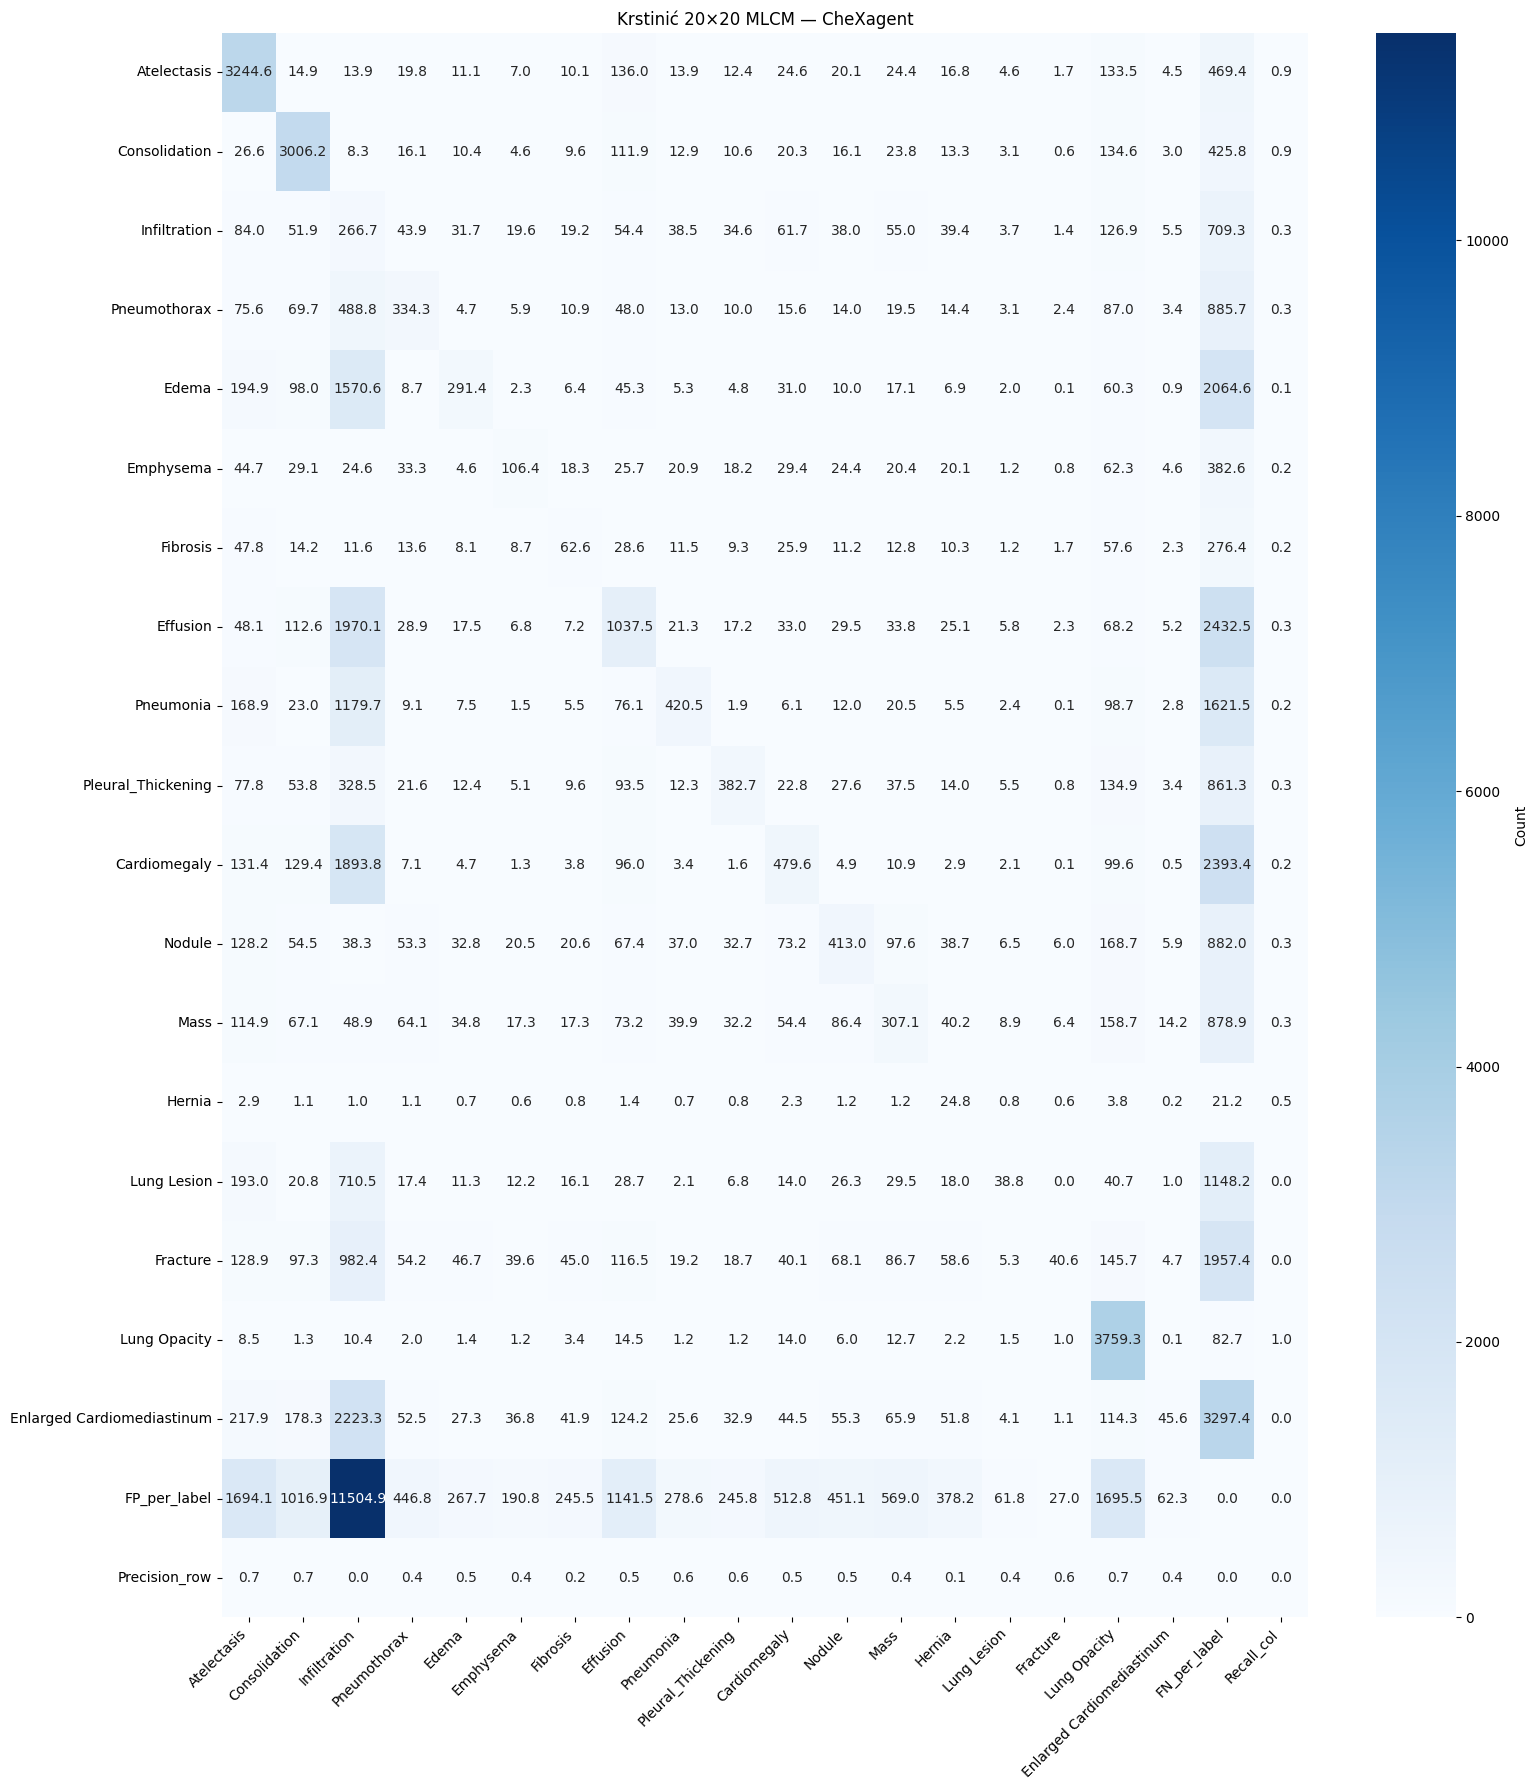

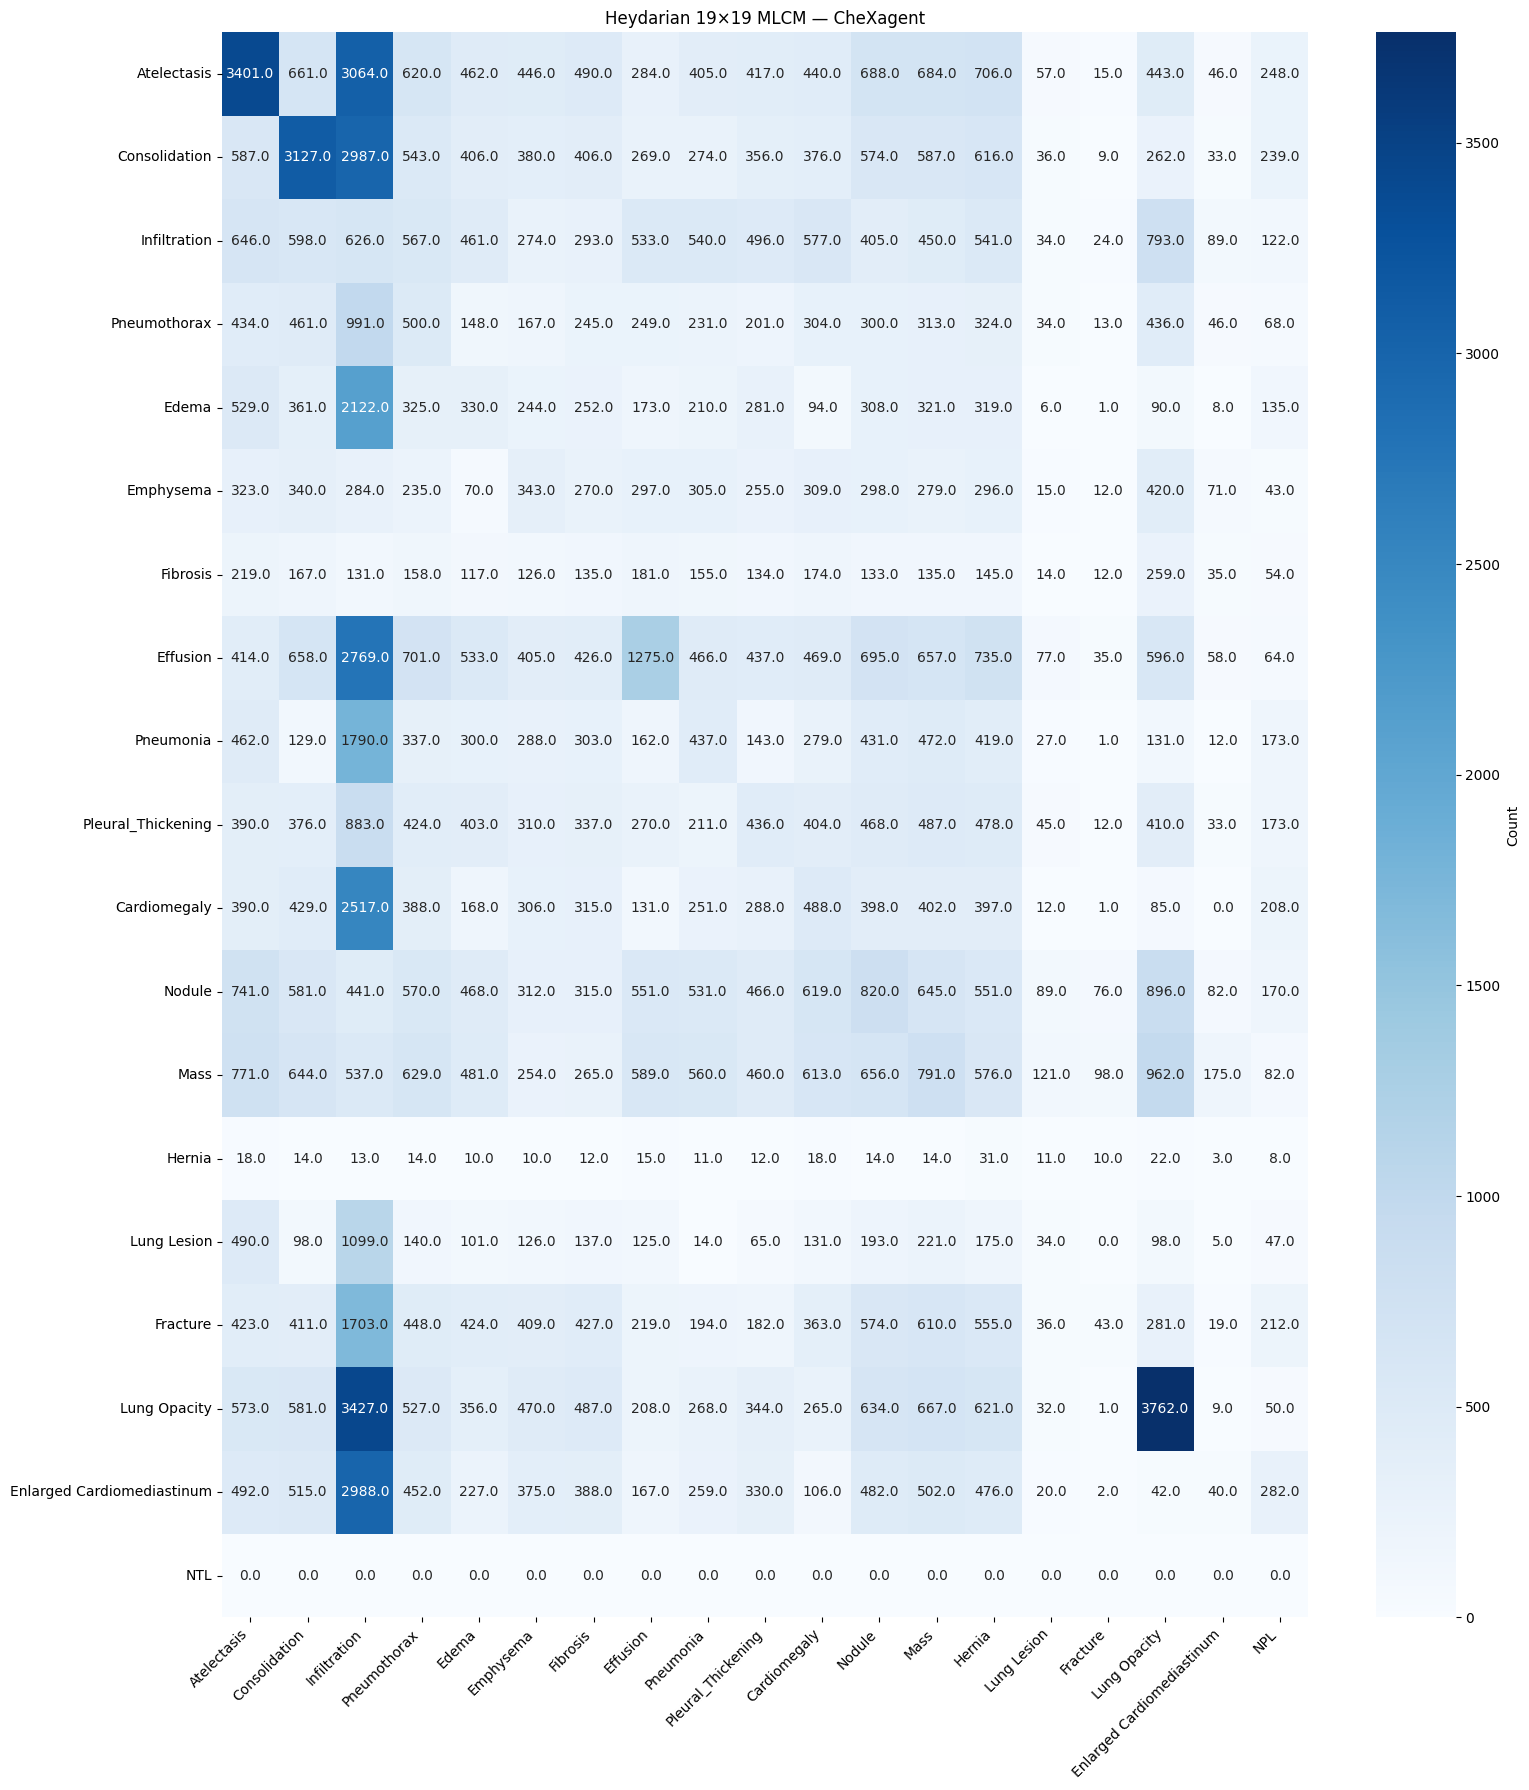

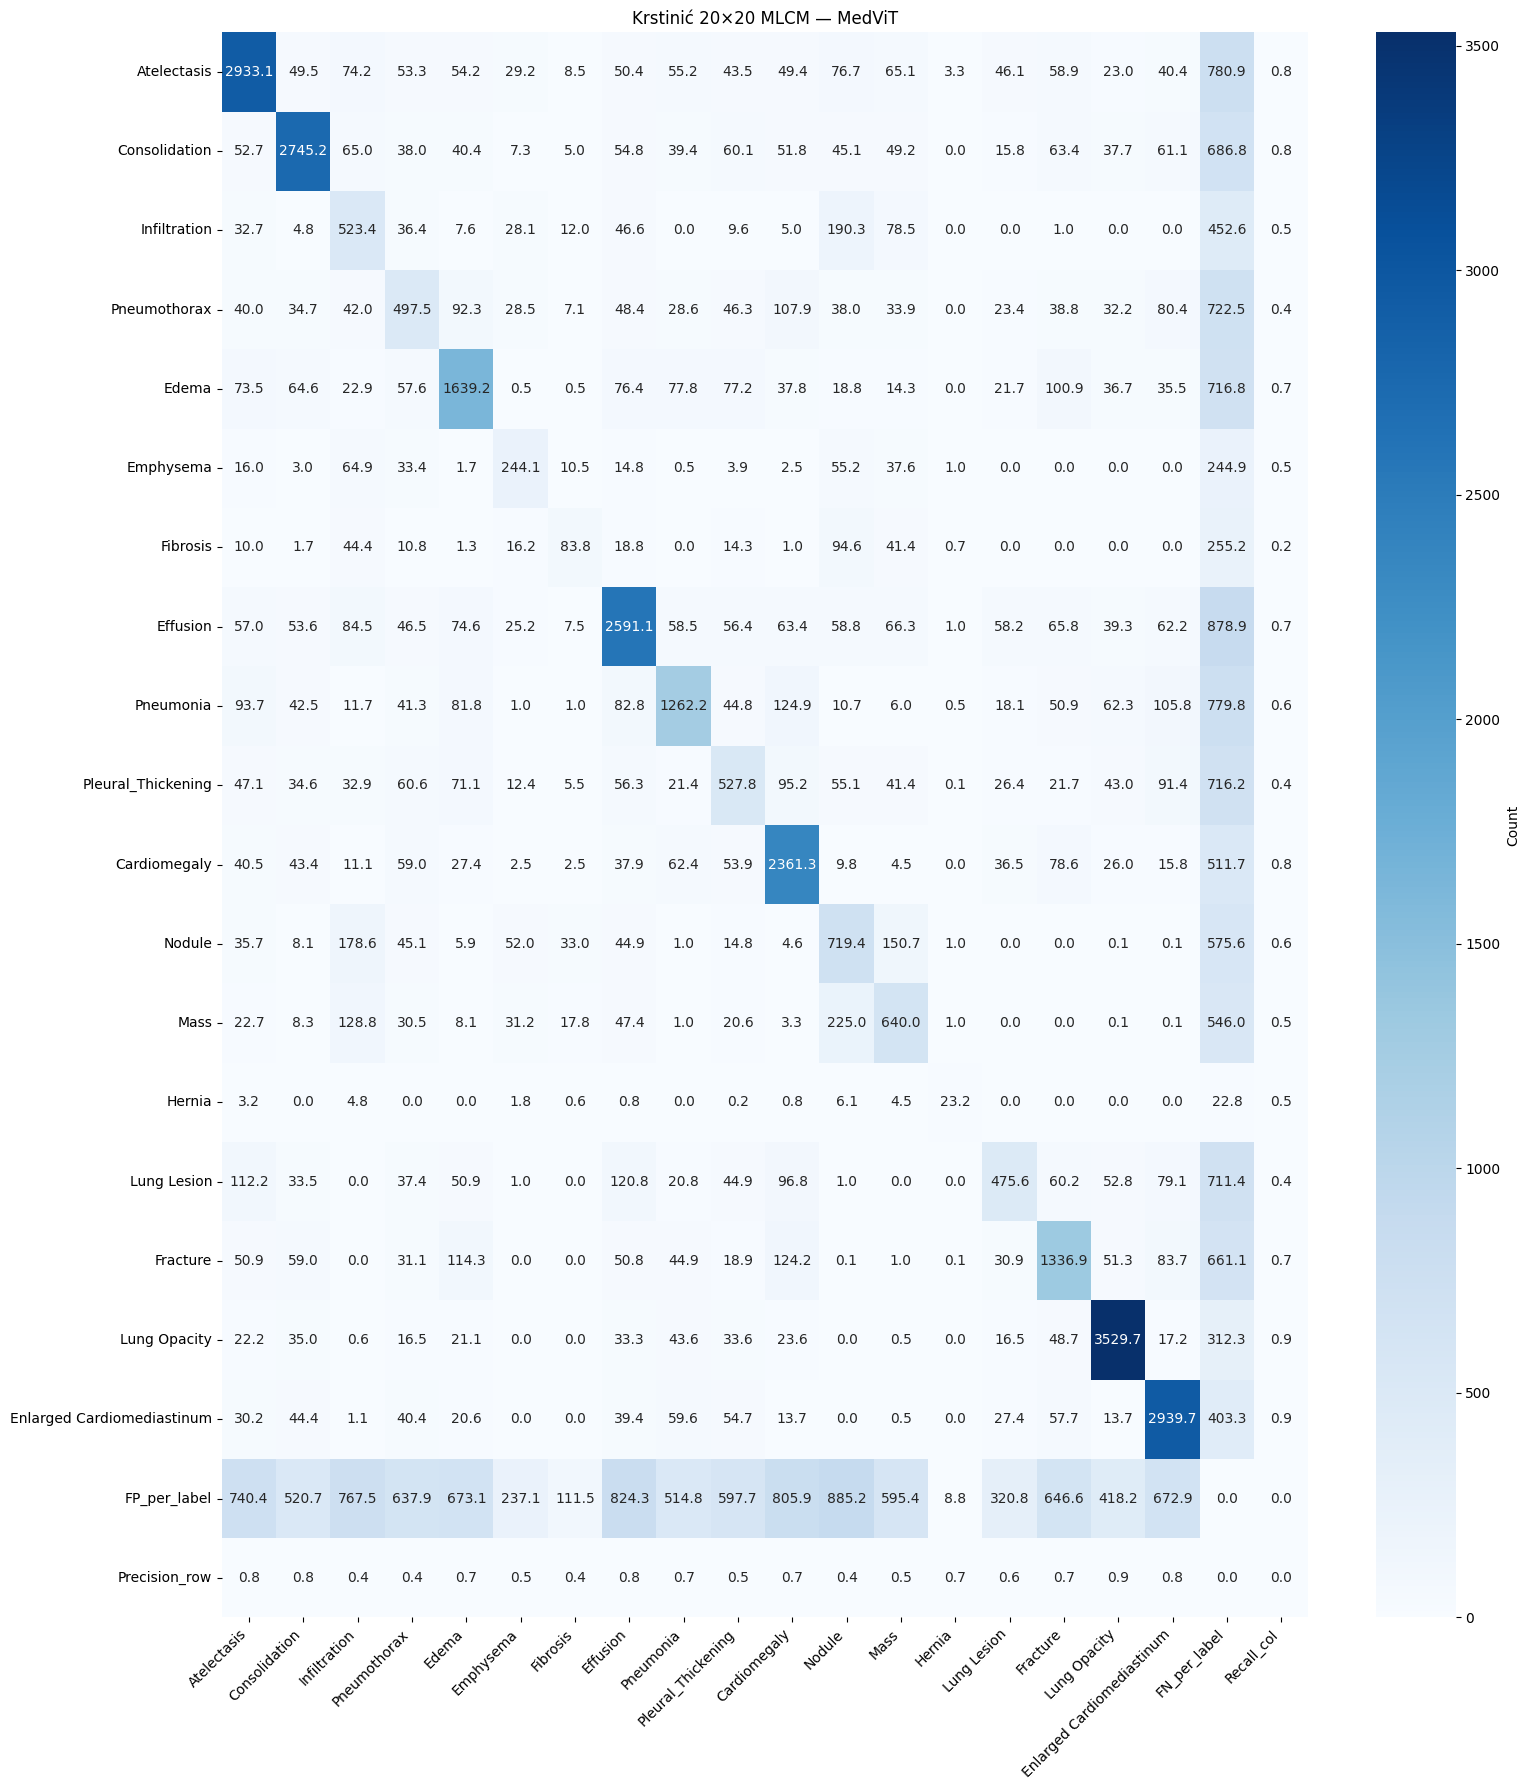

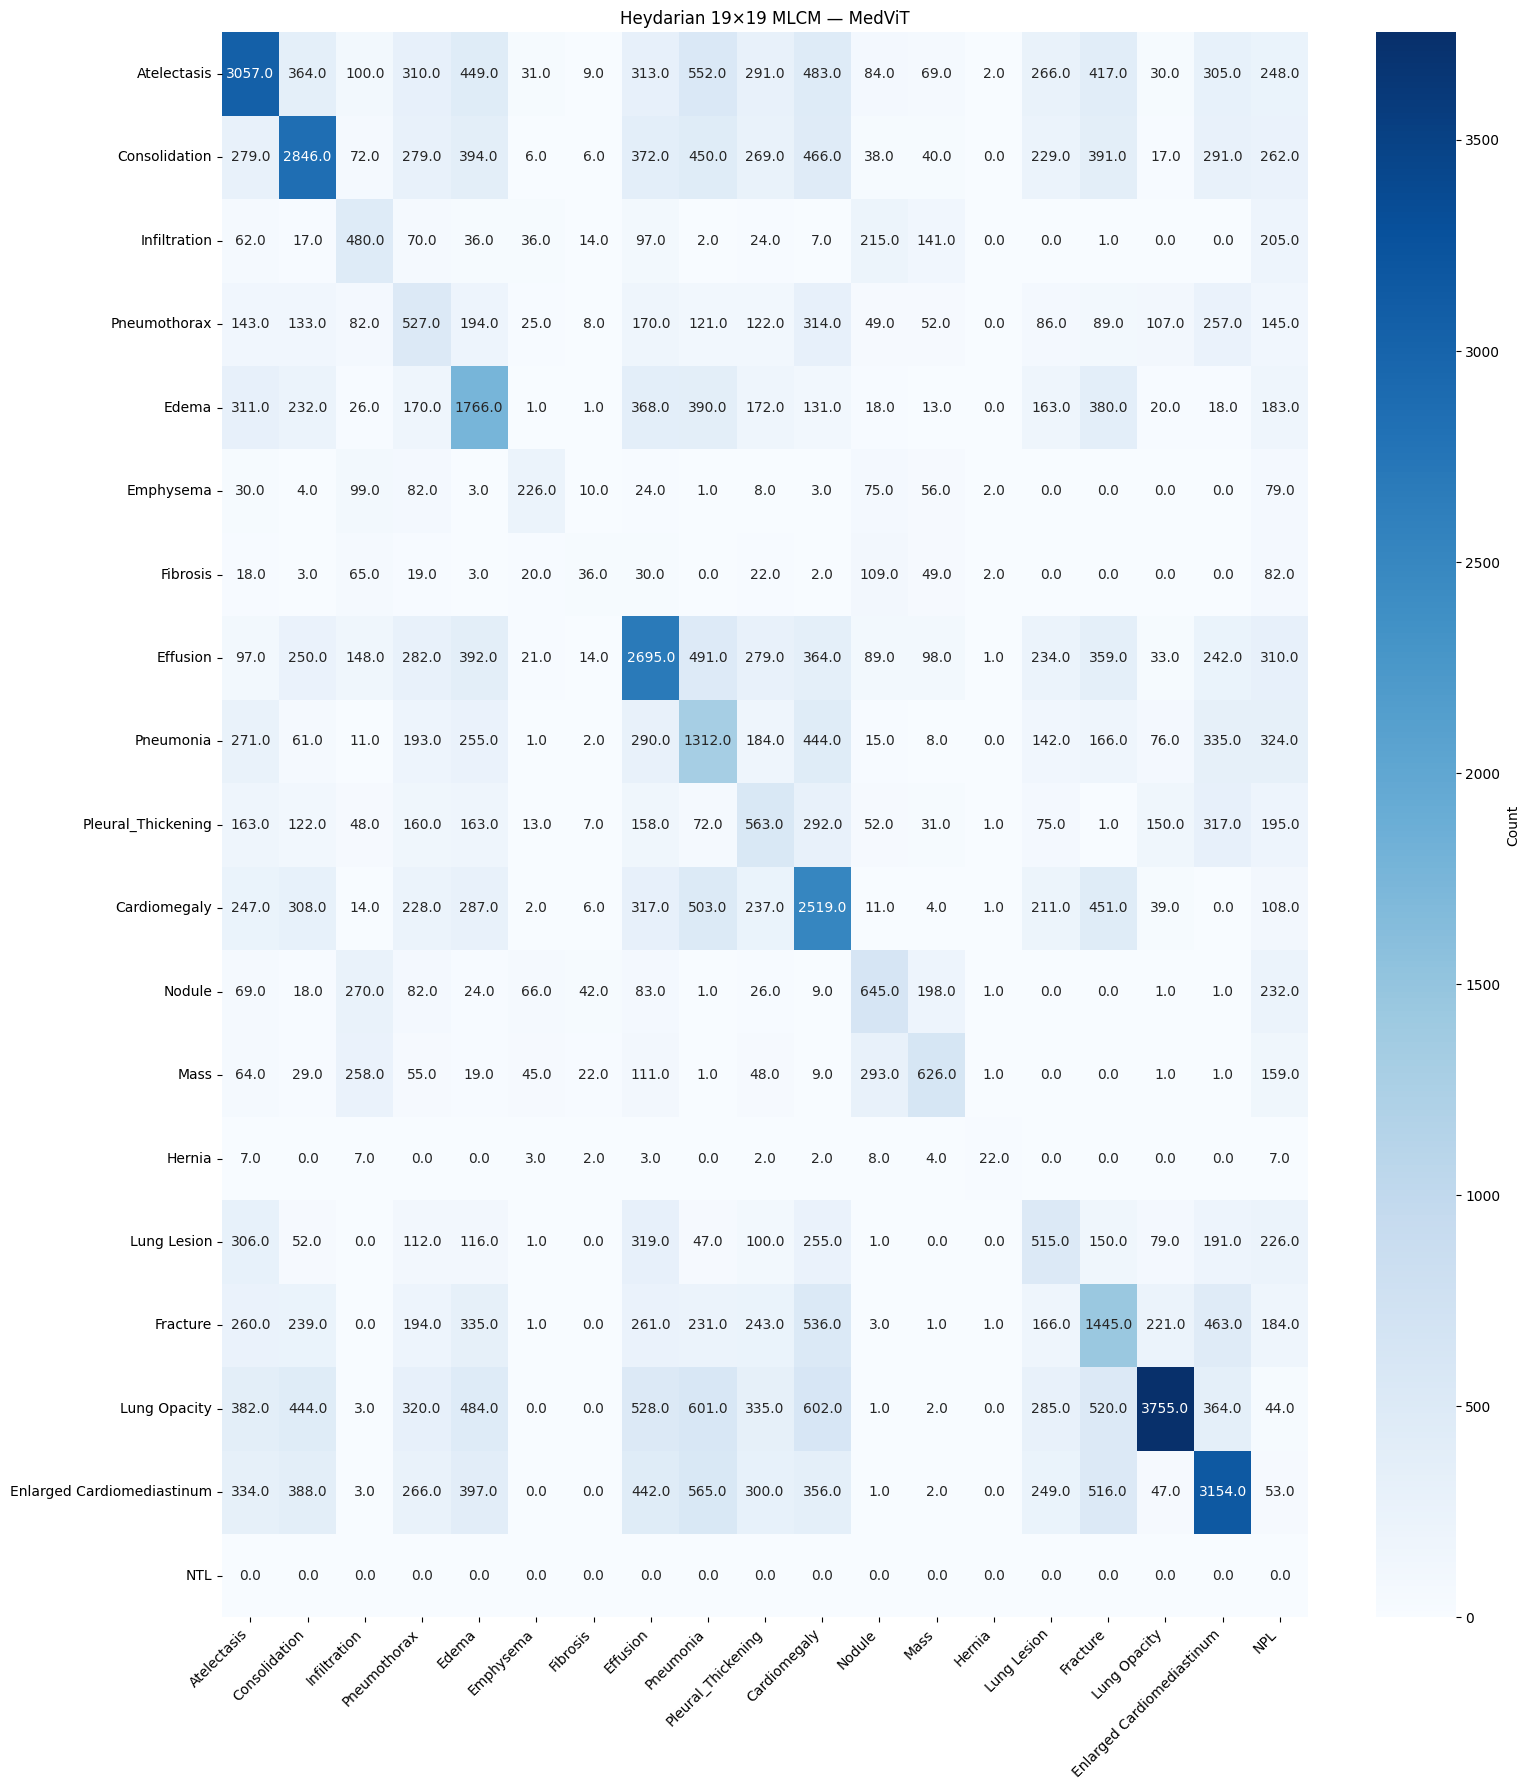

Done: all confusion matrices built, plotted, and saved.


In [25]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot + Save helper
# ─────────────────────────────────────────────────────────────────────────────
def plot_and_save(df, title, fname):
    plt.figure(figsize=(16,18))
    sns.heatmap(df, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=df.columns, yticklabels=df.index,
                cbar_kws={"label":"Count"})
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"{fname}.png")
    plt.show()
    plt.close()


# ─────────────────────────────────────────────────────────────────────────────
# Run for each model
# ─────────────────────────────────────────────────────────────────────────────
for model_name, df in data.items():
    y_t = df[[f"{l}_gt"   for l in LABELS]].values
    y_p = df[[f"{l}_pred" for l in LABELS]].values

    # Krstinić’s extended 20×20
    # raw Q×Q
    M_raw = build_krstinic_raw(y_t, y_p)

    # extended 20×20
    M_ext = extend_to_20x20(M_raw)

    # save + plot
    M_ext.to_csv(f"krstinic20x20_{model_name}.csv")
    plot_and_save(M_ext,
                  f"Krstinić 20×20 MLCM — {model_name}",
                  f"krstinic20x20_{model_name}")
    # Heydarian’s 19×19
    hm = heydarian_mlc(y_t, y_p, LABELS)
    hm.to_csv(f"heydarian19x19_{model_name}.csv")
    plot_and_save(hm, f"Heydarian 19×19 MLCM — {model_name}",
                  f"heydarian19x19_{model_name}")

print("Done: all confusion matrices built, plotted, and saved.")

In [12]:
import pandas as pd
import numpy as np

T_data = np.array([[1, 1, 0], [1, 0, 0], [0, 1, 1]])
T_df = pd.DataFrame(T_data, columns=['A', 'B', 'C'])

P_data = np.array([[1, 0, 1], [1, 1, 0], [0, 1, 0]])
P_df = pd.DataFrame(P_data, columns=['A', 'B', 'C'])

M_raw = build_krstinic_raw(T_data, P_data)

print(M_raw)

[[1.5 0.5 0. ]
 [0.  1.  1. ]
 [0.  1.  0. ]]
